In [85]:
import datetime
from functools import partial
from typing import List, Callable
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from itertools import product
import vectorbt as vbt

In [5]:
class Labeler:
    def __init__(self, name):
        """
        Initialize the labeler.

        Args:
        name (str): The name of the labeler.
        """
        self.name = name

    def fit(self, data):
        """
        Fit the labeler to the data.

        This method should be overridden by subclasses to implement
        the actual fitting logic.

        Args:
        data (any): The data to fit the labeler to.
        """
        raise NotImplementedError("Subclasses must implement this method.")

    def transform(self, data):
        """
        Transform the data into labels.

        This method should be overridden by subclasses to implement
        the actual transformation logic.

        Args:
        data (any): The data to transform into labels.

        Returns:
        any: The labels.
        """
        raise NotImplementedError("Subclasses must implement this method.")

class TripleBarrierLabeler(Labeler):
    def __init__(self, volatility_period=7, upper_barrier_factor=1, lower_barrier_factor=1, vertical_barrier=7, min_trend_days=2, barrier_type='volatility', touch_type="HL", up_label=2, neutral_label=1, down_label=0):
        """
        Initialize the labeler.
        """
        super().__init__(name="triple barrier labeling")
        self.volatility_period = volatility_period
        self.upper_barrier_factor = upper_barrier_factor
        self.lower_barrier_factor = lower_barrier_factor
        self.vertical_barrier = vertical_barrier
        self.min_trend_days = min_trend_days
        self.barrier_type = barrier_type
        self.touch_type = touch_type
        self.up_label = up_label
        self.down_label = down_label
        self.neutral_label = neutral_label

    def calculate_barriers(self, df, i, window):
        """calculate the barriers based on either volatility or returns of the backward window

        Args:
            df (pd.DataFrame): Data
            i (pd.index): the index of the beginning of the window
            window (int): window size

        Returns:
            df: Data including barriers for the forward window
        """
        end_window = min(i+window, len(df)-1)  # Ensure the window does not exceed the dataframe

        # Calculate the mean volatility or daily returns over the volatility_period
        if self.barrier_type == 'volatility':
            current_value = df.loc[i, 'volatility']
        elif self.barrier_type == 'returns':
            current_value = df.loc[i, 'daily_returns']
        else:
            raise ValueError("Invalid barrier_type. Choose either 'volatility' or 'returns'")

        df.loc[i:end_window, 'upper_barrier'] = df.loc[i, 'close'] + (df.loc[i, 'close'] * current_value * self.upper_barrier_factor)
        df.loc[i:end_window, 'lower_barrier'] = df.loc[i, 'close'] - (df.loc[i, 'close'] * current_value * self.lower_barrier_factor)
        return df

    def label_observations(self, df, origin, i, label):
        df.loc[origin:i+1, 'label'] = label
        return df

    def get_daily_vol(self, close, span0=100):
        """
        Calculate the daily volatility of closing prices.

        Parameters:
        - close: A pandas Series of closing prices.
        - span0: The span for the EWM standard deviation.

        Returns:
        - A pandas Series of daily volatility estimates.
        """
        # Find the start of the previous day for each day
        prev_day_start = close.index.searchsorted(close.index - pd.Timedelta(days=1))
        prev_day_start = prev_day_start[prev_day_start > 0]

        # Create a series with the start of the previous day for each day
        prev_day_start = pd.Series(close.index[prev_day_start - 1], index=close.index[close.shape[0] - prev_day_start.shape[0]:])

        # Calculate daily returns
        daily_returns = close.loc[prev_day_start.index] / close.loc[prev_day_start.values].values - 1

        # Calculate EWM standard deviation of daily returns
        daily_vol = daily_returns.ewm(span=span0).std()

        return daily_returns, daily_vol

    def fit(self, sdf):
        df = sdf.copy()
        # Calculate daily returns and volatility
        df['daily_returns'], df['volatility'] = self.get_daily_vol(df.close, self.volatility_period)

        df = df.reset_index()
        # Initialize label and window start
        df['label'] = self.neutral_label
        df['window_start'] = False

        self.data = df

    def transform(self):
        """
        Transform the data into labels.

        Returns:
        pd.DataFrame: The labels.
        """
        window = self.vertical_barrier
        origin = 0
        touch_upper = lambda high, barrier: high >= barrier
        touch_lower = lambda low, barrier: low <= barrier
        # For each observation
        for i in range(0, len(self.data)):
            # Define your barriers at the beginning of each window
            if i == origin:
                self.data = self.calculate_barriers(self.data, i, window)
                self.data.loc[i, 'window_start'] = True  # Mark the start of the window

            # one of the conditions were met
            if touch_upper(self.data.loc[i, "high" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "upper_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.up_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier
            elif touch_lower(self.data.loc[i, "low" if self.touch_type == 'HL' else 'close'], self.data.loc[i, "lower_barrier"]):
                if (i - origin > self.min_trend_days):
                    # label the observations
                    self.data = self.label_observations(self.data, origin, i, self.down_label)
                    # set new origin
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index
                    # reset window
                    window = self.vertical_barrier

            # none of the conditions were met
            else:
                if window > 0:
                    # reduce window size by one
                    window = window - 1
                else:
                    # reset window
                    window = self.vertical_barrier
                    # label neutral from origin to origin + window
                    self.data.loc[origin:min(origin+window, len(self.data)-1), 'label'] = self.neutral_label  # Ensure the window does not exceed the dataframe
                    # set origin to the next id
                    origin = i + 1 if i + 1 < len(self.data) else i  # Check if i + 1 is within the DataFrame's index

        self.data = self.data.set_index("timestamp")
        return self.data

def pandas_data_loader(addr: str, columns: List[str], *transforms: Callable[[pd.DataFrame], pd.DataFrame]) -> pd.DataFrame:
    # Load the data from the CSV file
    df = pd.read_csv(addr, usecols=columns)

    # Apply each transform to the DataFrame
    for transform in transforms:
        df = transform(df)

    return df

# Transform index to datetime
def index_to_datetime(df, unit="s"):
    df.index = pd.to_datetime(df.index, unit=unit)
    return df
# Transform col to index
to_index = lambda col, df: df.set_index(col)
# Rename text_plit to text
rename = lambda original, new, df: df.rename(columns={original: new})

In [27]:
# @title load price data
address = "../raw/bitcoin_2015-01-01_2022-01-01.csv" # @param {"type":"string","placeholder":"./raw/daily-2020.csv"}
# Loading the price data
columns = ["timestamp", "close", "open", "high", "low", "volume"]
price_df = pandas_data_loader(address, columns, partial(to_index, "timestamp"), partial(index_to_datetime, unit=None))
price_df = price_df.sort_index()
price_df = price_df[:"2021-02-01"]

In [28]:
# @title load text data
sentiment = True # @param {"type":"boolean","placeholder":"True"}
address = "../raw/impact_labeled.csv" # @param {"type":"string","placeholder":"./raw/labeled_tweets.csv"}
columns = ["text", "impact_label", "date"]
text_df = pandas_data_loader(address, columns, partial(to_index, "date"), partial(index_to_datetime, unit='ns'), partial(rename, "text_split", "text"))
# text_df = text_df["2020-01-01":"2021-01-01"]

In [29]:
volatility = price_df['close'].pct_change().rolling(window=30).std()

In [30]:
def generate_signal_and_size(row, bearish_threshold=0.8, bullish_threshold=1.2):
    if row < bearish_threshold:
        return -1, abs(row - bearish_threshold)  # Bearish signal and position size
    elif row > bullish_threshold:
        return 1, abs(row - bullish_threshold)  # Bullish signal and position size
    else:
        return 0, 0  # Neutral signal and position size

means = text_df["impact_label"].groupby(text_df.index).mean()
means = pd.DataFrame(means)
means["signal"], means["position_size"] = zip(*means["impact_label"].apply(generate_signal_and_size))

In [31]:
means = text_df["impact_label"].groupby(text_df.index).mean()
means = pd.DataFrame(means)
means["signal"], means["position_size"] = zip(*means["impact_label"].apply(generate_signal_and_size))

In [32]:
scaler = MinMaxScaler(feature_range=(0, 1))
position_sizes = means[['position_size']]  # Ensure it's a DataFrame
means['position_size'] = scaler.fit_transform(position_sizes)

In [33]:
price_df = price_df.merge(means[['signal', 'position_size']], left_index=True, right_index=True, how='left')
price_df['volatility'] = volatility
price_df.fillna(0, inplace=True)

## In-Out-Signal-Long

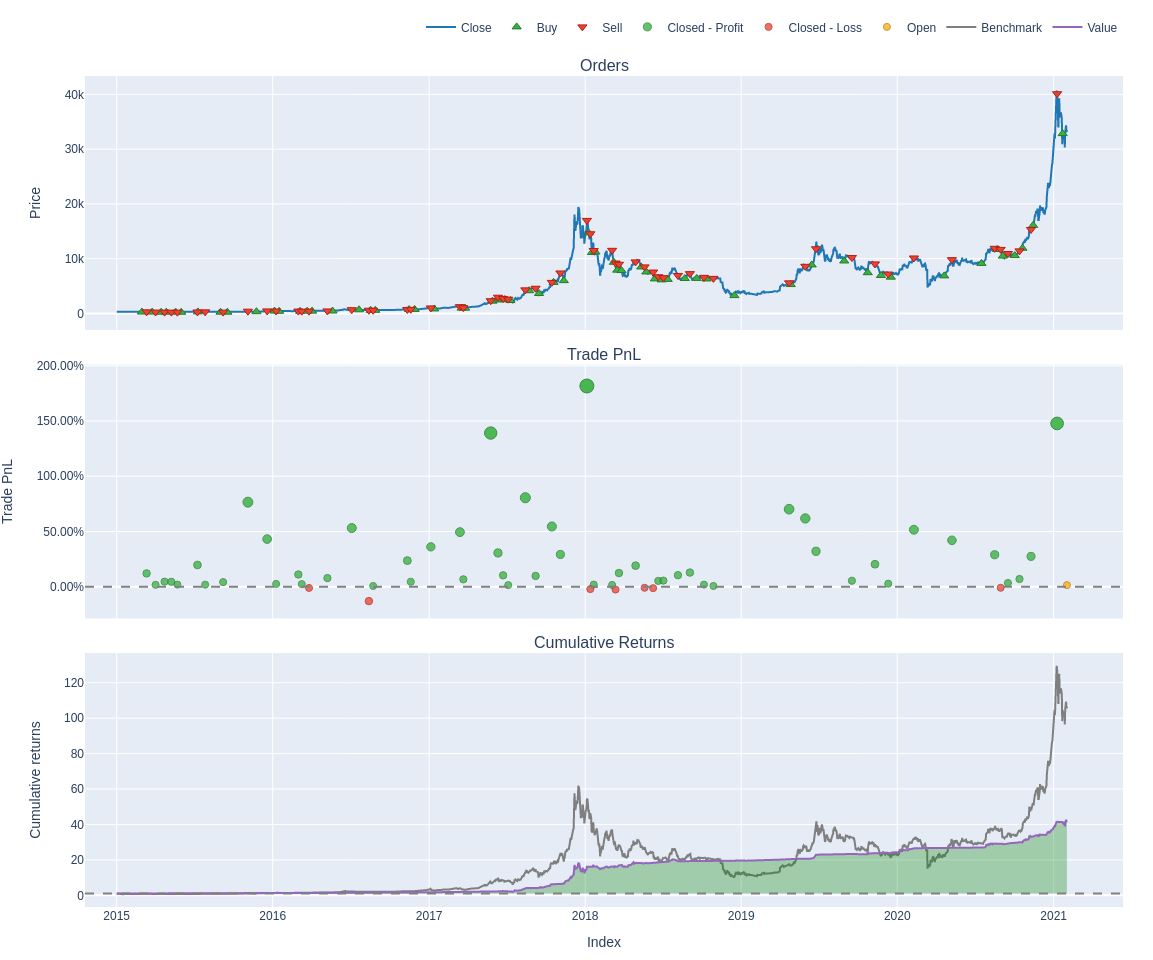

In [34]:
# Define the strategy
entries = price_df['signal'] > 0
exits = price_df['signal'] < 0
size = price_df['position_size']

pf = vbt.Portfolio.from_signals(
    close=price_df['close'],
    entries=entries,
    exits=exits,
    size=size,
    tp_stop=price_df['close'] * (1 + price_df['volatility']),
    sl_stop=price_df['close'] * (1 - price_df['volatility']),
    init_cash=1000,  # Initial cash value
    fees=0.005  # Commission fees (0.5%)
)

# Run the backtest
pf.plot().show()

In [35]:
pf.stats()

Start                                2015-01-01 00:00:00
End                                  2021-02-01 00:00:00
Period                                2224 days 00:00:00
Start Value                                       1000.0
End Value                                   41955.412785
Total Return [%]                             4095.541278
Benchmark Return [%]                        10568.449715
Max Gross Exposure [%]                         93.895923
Total Fees Paid                              2046.882142
Max Drawdown [%]                                32.10025
Max Drawdown Duration                  257 days 00:00:00
Total Trades                                          61
Total Closed Trades                                   60
Total Open Trades                                      1
Open Trade PnL                                483.970116
Win Rate [%]                                   88.333333
Best Trade [%]                                181.642129
Worst Trade [%]                

## In-Out-Signal-Short

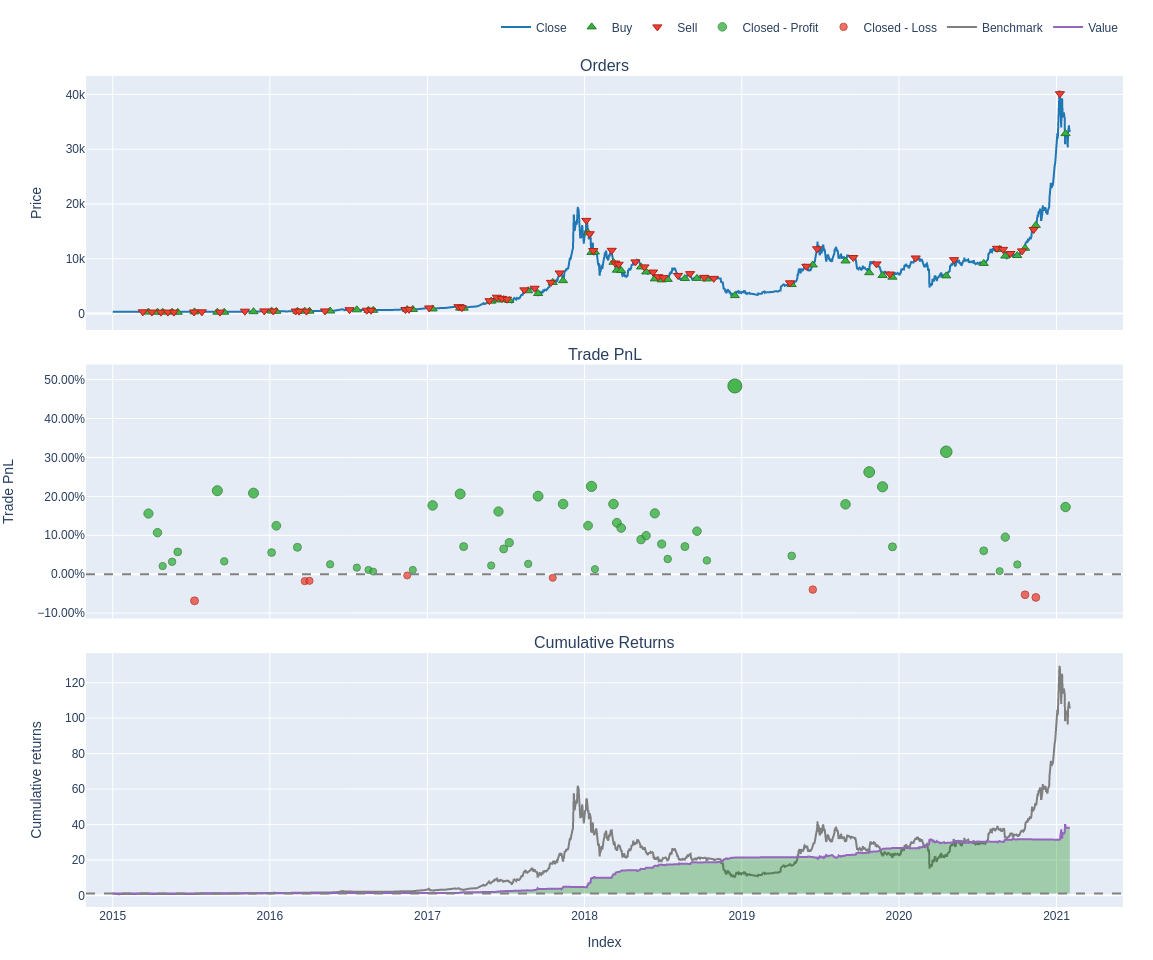

In [64]:
# Define the strategy
long_entries = price_df['signal'] > 0
long_exits = price_df['signal'] < 0
short_entries = price_df['signal'] < 0
short_exits = price_df['signal'] > 0
size = price_df['position_size']

# Run the backtest
pf = vbt.Portfolio.from_signals(
    close=price_df['close'],
    short_entries=short_entries,
    short_exits=short_exits,
    size=size,
    # tp_stop=price_df['volatility'],  # TP as a percentage
    # sl_stop=price_df['volatility'],  # SL as a percentage
    init_cash=1000,  # Initial cash value
    fees=0.005  # Commission fees (0.5%)
)

# Plot the results
pf.plot().show()

In [65]:
pf.stats()

Start                                2015-01-01 00:00:00
End                                  2021-02-01 00:00:00
Period                                2224 days 00:00:00
Start Value                                       1000.0
End Value                                   38135.460131
Total Return [%]                             3713.546013
Benchmark Return [%]                        10568.449715
Max Gross Exposure [%]                      32536.567853
Total Fees Paid                              2796.200725
Max Drawdown [%]                               16.357189
Max Drawdown Duration                  192 days 00:00:00
Total Trades                                          60
Total Closed Trades                                   60
Total Open Trades                                      0
Open Trade PnL                                       0.0
Win Rate [%]                                   86.666667
Best Trade [%]                                 48.372582
Worst Trade [%]                

## Buy-And-Hold

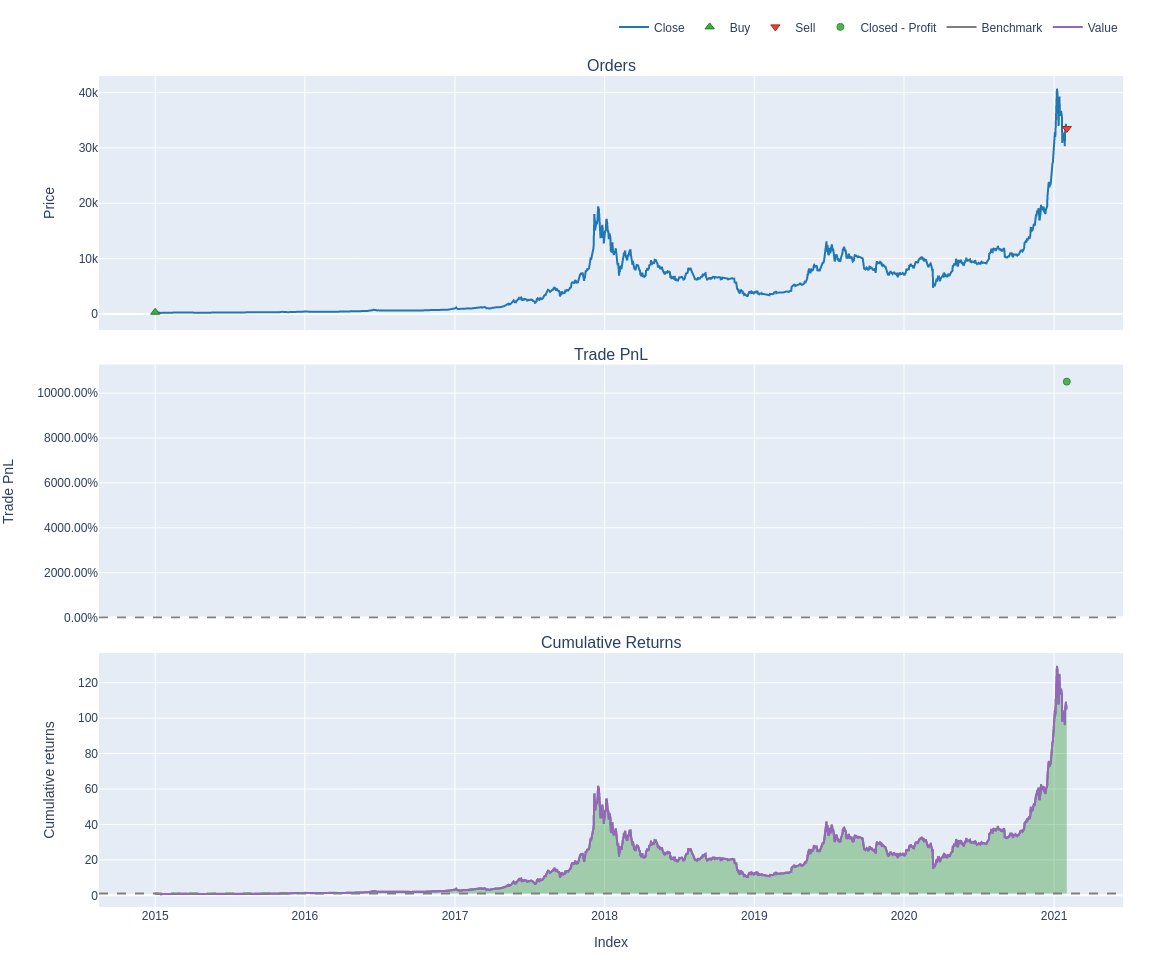

In [22]:
# Define the strategy
entries = pd.Series([True] + [False] * (len(price_df) - 1), index=price_df.index)
exits = pd.Series([False] * (len(price_df) - 1) + [True], index=price_df.index)

# Run the backtest
pf = vbt.Portfolio.from_signals(
    close=price_df['close'],
    entries=entries,
    exits=exits,
    init_cash=1000,  # Initial cash
    fees=0.005  # Commission fees
)

# Plot the results
pf.plot().show()

In [23]:
pf.stats()

Start                         2015-01-01 00:00:00
End                           2021-02-01 00:00:00
Period                         2224 days 00:00:00
Start Value                                1000.0
End Value                           105622.959861
Total Return [%]                     10462.295986
Benchmark Return [%]                 10568.449715
Max Gross Exposure [%]                      100.0
Total Fees Paid                        535.743767
Max Drawdown [%]                        83.339569
Max Drawdown Duration          1079 days 00:00:00
Total Trades                                    1
Total Closed Trades                             1
Total Open Trades                               0
Open Trade PnL                                0.0
Win Rate [%]                                100.0
Best Trade [%]                       10514.607466
Worst Trade [%]                      10514.607466
Avg Winning Trade [%]                10514.607466
Avg Losing Trade [%]                          NaN


## Optimization

  0%|          | 0/2401 [00:00<?, ?it/s]

Best Parameters: {'volatility_period': 11, 'upper_barrier_factor': 1.4, 'lower_barrier_factor': 1.3, 'vertical_barrier': 13, 'barrier_type': 'volatility', 'touch_type': 'HL'}
Best Sharpe Ratio: 2.4003444759115564


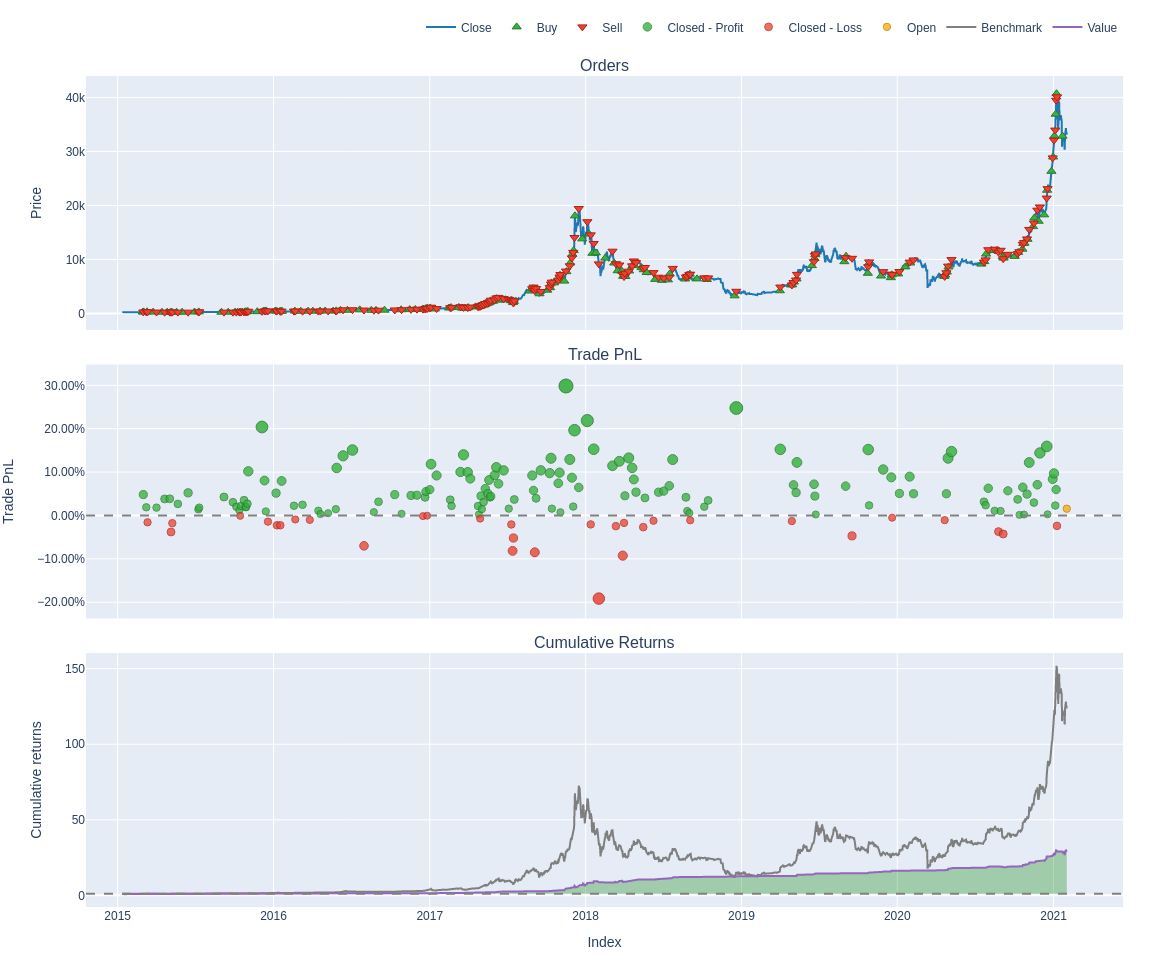

In [89]:
import pandas as pd
import vectorbt as vbt
from itertools import product
from tqdm.auto import tqdm

# Define the parameter grid
param_grid = {
    'volatility_period': [10, 11, 12, 13, 14, 15, 16],
    'upper_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6],
    'lower_barrier_factor': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6],
    'vertical_barrier': [10, 11, 12, 13, 14, 15, 16],
    'barrier_type': ['volatility'],
    'touch_type': ['HL']
}

# Function to evaluate the strategy
def evaluate_strategy(params):
    labeler = TripleBarrierLabeler(**params)
    labeler.fit(price_df)
    labeled_df = labeler.transform()
    
    # Calculate the percentage changes for TP and SL
    labeled_df['tp_stop'] = (labeled_df['upper_barrier'] - labeled_df['close']) / labeled_df['close']
    labeled_df['sl_stop'] = (labeled_df['close'] - labeled_df['lower_barrier']) / labeled_df['close']
    
    # Replace negative values with 0
    labeled_df['tp_stop'] = labeled_df['tp_stop'].apply(lambda x: max(x, 0))
    labeled_df['sl_stop'] = labeled_df['sl_stop'].apply(lambda x: max(x, 0))
    
    # Define the strategy
    entries = labeled_df['signal'] > 0
    exits = labeled_df['signal'] < 0
    size = labeled_df['position_size']
    
    # Run the backtest
    pf = vbt.Portfolio.from_signals(
        close=labeled_df['close'],
        entries=entries,
        exits=exits,
        size=size,
        tp_stop=labeled_df['tp_stop'],
        sl_stop=labeled_df['sl_stop'],
        init_cash=1000,  # Initial cash value
        fees=0.005  # Commission fees (0.5%)
    )
    
    # Return the Sharpe ratio as the evaluation metric
    return pf.sharpe_ratio()

# Optimize parameters
best_params = None
best_sharpe_ratio = -float('inf')

# Use tqdm to show progress
for params in tqdm(product(*param_grid.values()), total=len(list(product(*param_grid.values())))):
    params_dict = dict(zip(param_grid.keys(), params))
    sharpe_ratio = evaluate_strategy(params_dict)
    
    if sharpe_ratio > best_sharpe_ratio:
        best_sharpe_ratio = sharpe_ratio
        best_params = params_dict

print("Best Parameters:", best_params)
print("Best Sharpe Ratio:", best_sharpe_ratio)

Best Parameters: {'volatility_period': 11, 'upper_barrier_factor': 1.4, 'lower_barrier_factor': 1.3, 'vertical_barrier': 13, 'barrier_type': 'volatility', 'touch_type': 'HL'}

In [91]:
best_parameters = {'volatility_period': 11, 'upper_barrier_factor': 1.4, 'lower_barrier_factor': 1.3, 'vertical_barrier': 13, 'barrier_type': 'volatility', 'touch_type': 'HL'}

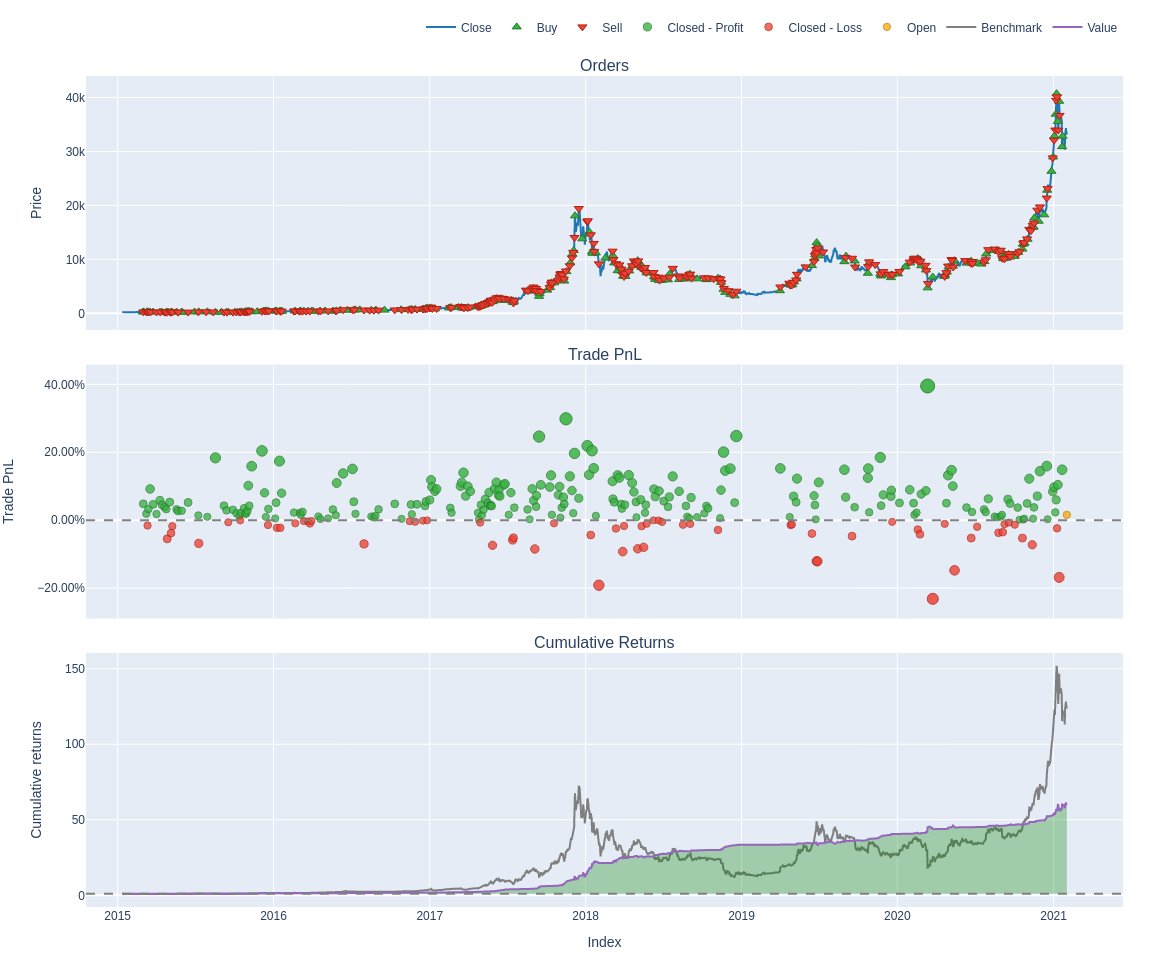

In [98]:
# Apply the optimized parameters to label the data
labeler = TripleBarrierLabeler(**best_params)
labeler.fit(price_df)
price_df = labeler.transform()

# Calculate the percentage changes for TP and SL
price_df['tp_stop'] = (price_df['upper_barrier'] - price_df['close']) / price_df['close']
price_df['sl_stop'] = (price_df['close'] - price_df['lower_barrier']) / price_df['close']
# Replace negative values with 0
price_df['tp_stop'] = price_df['tp_stop'].apply(lambda x: max(x, 0))
price_df['sl_stop'] = price_df['sl_stop'].apply(lambda x: max(x, 0))

# Define the strategy
entries = price_df['signal'] > 0
short_entries = price_df['signal'] < 0
size = price_df['position_size']

# Run the backtest
pf = vbt.Portfolio.from_signals(
    close=price_df['close'],
    entries=entries,
    short_entries=short_entries,
    # exits=exits,
    size=size,
    tp_stop=price_df['tp_stop'],
    sl_stop=price_df['sl_stop'],
    init_cash=1000,  # Initial cash value
    fees=0.005  # Commission fees (0.5%)
)

# Plot the results
pf.plot().show()

In [99]:
pf.stats()

Start                               2015-01-12 00:00:00
End                                 2021-02-01 00:00:00
Period                               2213 days 00:00:00
Start Value                                      1000.0
End Value                                  60633.234843
Total Return [%]                            5963.323484
Benchmark Return [%]                       12407.815629
Max Gross Exposure [%]                      2183.335589
Total Fees Paid                             12746.50185
Max Drawdown [%]                              20.552148
Max Drawdown Duration                 100 days 00:00:00
Total Trades                                        291
Total Closed Trades                                 290
Total Open Trades                                     1
Open Trade PnL                               483.970116
Win Rate [%]                                  77.931034
Best Trade [%]                                39.517543
Worst Trade [%]                              -23